
This notebook contains the code used in the BigComp 2022 paper: <br>
<b>Heeryon Cho, Woo-Kyu Kang, Younsoo Park, Sungeu Chae, and Seong-joon Kim, "Multi-label Facial Emotion Recognition Using Korean Drama Movie Clips," BigComp 2022.</b>
### Autoencoder /  Classify Multi-label Emotions

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rn
import os

In [2]:
import warnings
import logging
logging.getLogger('tensorflow').disabled = True
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
# Record cell run time.
!pip install ipython-autotime

%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 4.6 MB/s 
time: 542 µs (started: 2022-11-20 18:05:05 +00:00)


In [4]:
# Set seed for reproducibility.

set_seed = 46
np.random.seed(set_seed)
rn.seed(set_seed)
tf.random.set_seed(set_seed)

time: 1.28 ms (started: 2022-11-20 18:05:05 +00:00)


### Load pretrained autoencoder.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
time: 15.9 s (started: 2022-11-20 18:05:07 +00:00)


In [6]:
# Create autoencoder model (skeleton) for loading pretrained weights.

def create_autoencoder():
    # Define the model
    model = Sequential()

    #1st convolution layer
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(64,64,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

    #2nd convolution layer
    model.add(Conv2D(32,(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

    #3rd convolution layer
    model.add(Conv2D(32,(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))    

    #1st deconvolution layer
    model.add(Conv2DTranspose(32,(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(UpSampling2D((2, 2)))
    
    #2nd deconvolution layer
    model.add(Conv2DTranspose(32,(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(UpSampling2D((2, 2)))

    #3rd deconvolution layer
    model.add(Conv2DTranspose(32,(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(UpSampling2D((2, 2)))    

    model.add(Conv2D(3,(3, 3), padding='same'))
    model.add(Activation('sigmoid'))
    
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy')
    model.summary()
    
    return model

time: 8.47 ms (started: 2022-11-20 18:05:23 +00:00)


In [7]:
# Load pretrained autoencoder weights.

checkpoint_path = "/content/drive/MyDrive/facial_emotion_recognition_using_K-drama_dataset-main/model/autoencoder.ckpt"
autoencoder = create_autoencoder()
autoencoder.load_weights(checkpoint_path)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                    

time: 4.49 s (started: 2022-11-20 18:05:27 +00:00)


### The below code is for creating training data tfrecord and idx file from images. (We do not use the below code in this jupyter notebook since we import tfrecords directly.)

```python
# The following functions can be used to convert a value to a type compatible
# with tf.train.Example.

from itertools import islice
from subprocess import call

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

#def _float_feature(value):
#    """Returns a float_list from a float / double."""
#    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    if type(value) != list:
        value = [value]
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

# Create a dictionary with relevant features.

def image_example(image_string, label):
    image_shape = tf.io.decode_jpeg(image_string).shape

    feature = {
        'height': _int64_feature(image_shape[0]),
        'width': _int64_feature(image_shape[1]),
        'depth': _int64_feature(image_shape[2]),
        'label': _int64_feature(label),
        'image_raw': _bytes_feature(image_string),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def gen_tfrecord_idx(tfrecord_file, dict_label, tfrecord_idx):
    with tf.io.TFRecordWriter(tfrecord_file) as writer:
        for filename, label in dict_label.items():
            fname = "./image/" + filename
            image_string = open(fname, 'rb').read()
            tf_example = image_example(image_string, label)
            writer.write(tf_example.SerializeToString())

    tfrecord2idx_script = "tfrecord2idx"

    if not os.path.isfile(tfrecord_idx):
        call([tfrecord2idx_script, tfrecord_file, tfrecord_idx])


#--------------------------------------------
# VALID DATA: Load labels, check headers, check data shape.

df_label_valid = pd.read_csv('label/label_multi-label_valid.csv')
print("valid columns:", df_label_valid.columns)
print("valid shape:", df_label_valid.shape)

# Place labels into a dictionary.

dict_label_valid = {}
for idx, row in df_label_valid.iterrows():
    dict_label_valid[row['img_id']] = list(row['moved':'disgusted'].values)
len(dict_label_valid)

#--------------------------------------------
# Create VALID tfrecord & idx files from jpg images.

tfrecord_file_valid = './tfrecords/multi-label_valid.tfrecords'
tfrecord_idx_valid = './tfrecords/multi-label_valid.idx'

gen_tfrecord_idx(tfrecord_file_valid, dict_label_valid, tfrecord_idx_valid)

#--------------------------------------------
# TRAIN DATA: Load labels, check headers, check data shape.

df_label_train = pd.read_csv('label/label_multi-label_train.csv')
print("train columns:", df_label_train.columns)
print("train shape:", df_label_train.shape)

# Place labels into a dictionary.

dict_label_train = {}
for idx, row in df_label_train.iterrows():
    dict_label_train[row['img_id']] = list(row['moved':'disgusted'].values)
len(dict_label_train)

#--------------------------------------------
# Create TRAIN tfrecord & idx files from jpg images.

tfrecord_file_train = './tfrecords/multi-label_train.tfrecords'
tfrecord_idx_train = './tfrecords/multi-label_train.idx'

gen_tfrecord_idx(tfrecord_file_train, dict_label_train, tfrecord_idx_train) 

#--------------------------------------------
# TEST DATA: Load labels, check headers, check data shape.

df_label_test = pd.read_csv('label/label_multi-label_test.csv')
print("test columns:", df_label_test.columns)
print("test shape:", df_label_test.shape)

# Place labels into a dictionary.

dict_label_test = {}
for idx, row in df_label_test.iterrows():
    dict_label_test[row['img_id']] = list(row['moved':'disgusted'].values)
len(dict_label_test)

#-------------------------------------------
# Create TEST tfrecord & idx files from jpg images.

tfrecord_file_test = './tfrecords/multi-label_test.tfrecords'
tfrecord_idx_test = './tfrecords/multi-label_test.idx'

gen_tfrecord_idx(tfrecord_file_test, dict_label_test, tfrecord_idx_test) 

# OUTPUT
# valid columns: Index(['img_id', 'clip_id', 'moved', 'fearful', 'bored', 'surprised', 'angry',
#       'anxious', 'smitten', 'fluttered', 'disappointed', 'fulfilled',
#       'ashamed', 'sad', 'upset', 'sympathetic', 'passionate', 'depressed',
#       'amused', 'affectionate', 'guilty', 'neutral', 'jealous', 'peaceful',
#       'happy', 'disgusted'],
#       dtype='object')
# valid shape: (3882, 26)
# train columns: Index(['img_id', 'clip_id', 'moved', 'fearful', 'bored', 'surprised', 'angry',
#       'anxious', 'smitten', 'fluttered', 'disappointed', 'fulfilled',
#       'ashamed', 'sad', 'upset', 'sympathetic', 'passionate', 'depressed',
#       'amused', 'affectionate', 'guilty', 'neutral', 'jealous', 'peaceful',
#       'happy', 'disgusted'],
#       dtype='object')
# train shape: (31053, 26)
# test columns: Index(['img_id', 'clip_id', 'moved', 'fearful', 'bored', 'surprised', 'angry',
#       'anxious', 'smitten', 'fluttered', 'disappointed', 'fulfilled',
#       'ashamed', 'sad', 'upset', 'sympathetic', 'passionate', 'depressed',
#       'amused', 'affectionate', 'guilty', 'neutral', 'jealous', 'peaceful',
#       'happy', 'disgusted'],
#       dtype='object')
# test shape: (3882, 26)
```    

### Load label data.

In [9]:
# Load labels, check headers, check data shape.

df_label = pd.read_csv('/content/drive/MyDrive/facial_emotion_recognition_using_K-drama_dataset-main/label/label_multi-label.csv')
print(df_label.columns)
print(df_label.shape)

LABELS = list(df_label.columns[2:])
print("LABELS=", LABELS)
print("All classes:", len(LABELS))

label_valid = pd.read_csv('/content/drive/MyDrive/facial_emotion_recognition_using_K-drama_dataset-main/label/label_multi-label_valid.csv')
label_train = pd.read_csv('/content/drive/MyDrive/facial_emotion_recognition_using_K-drama_dataset-main/label/label_multi-label_train.csv')
label_test = pd.read_csv('/content/drive/MyDrive/facial_emotion_recognition_using_K-drama_dataset-main/label/label_multi-label_test.csv')

VALID_DATA_SIZE = label_valid.shape[0]
TRAIN_DATA_SIZE = label_train.shape[0]
TEST_DATA_SIZE = label_test.shape[0]

print("TRAIN_DATA_SIZE:", label_train.shape[0])
print("VALID_DATA_SIZE:", label_valid.shape[0])
print("TEST_DATA_SIZE:", label_test.shape[0])

Index(['img_id', 'clip_id', 'moved', 'fearful', 'bored', 'surprised', 'angry',
       'anxious', 'smitten', 'fluttered', 'disappointed', 'fulfilled',
       'ashamed', 'sad', 'upset', 'sympathetic', 'passionate', 'depressed',
       'amused', 'affectionate', 'guilty', 'neutral', 'jealous', 'peaceful',
       'happy', 'disgusted'],
      dtype='object')
(38817, 26)
LABELS= ['moved', 'fearful', 'bored', 'surprised', 'angry', 'anxious', 'smitten', 'fluttered', 'disappointed', 'fulfilled', 'ashamed', 'sad', 'upset', 'sympathetic', 'passionate', 'depressed', 'amused', 'affectionate', 'guilty', 'neutral', 'jealous', 'peaceful', 'happy', 'disgusted']
All classes: 24
TRAIN_DATA_SIZE: 31053
VALID_DATA_SIZE: 3882
TEST_DATA_SIZE: 3882
time: 2.02 s (started: 2022-11-20 18:06:05 +00:00)


### Define training pipeline.

In [11]:
#https://docs.nvidia.com/deeplearning/dali/user-guide/docs/installation.html
!pip install --extra-index-url https://developer.download.nvidia.com/compute/redist --upgrade nvidia-dali-cuda102
!pip install --extra-index-url https://developer.download.nvidia.com/compute/redist --upgrade nvidia-dali-tf-plugin-cuda102


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://developer.download.nvidia.com/compute/redist
     |████████████████████████████████| 297.2 MB 17 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://developer.download.nvidia.com/compute/redist
     |████████████████████████████████| 333 kB 2.7 MB/s 
  Created wheel for nvidia-dali-tf-plugin-cuda102: filename=nvidia_dali_tf_plugin_cuda102-1.19.0-cp37-cp37m-linux_x86_64.whl size=120636 sha256=31f60f8800586e72a93824633e23cf19a87bc706a2f75e0b0da0e5bc8a8256c5
  Stored in directory: /root/.cache/pip/wheels/97/97/59/545e6b1324a7c6f16ee7daaa70f834c977281ef341eb0d9a76
Successfully built nvidia-dali-tf-plugin-cuda102
time: 49.8 s (started: 2022-11-20 18:07:34 +00:00)


In [12]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.fn as fn
import nvidia.dali.types as types
import nvidia.dali.tfrecord as tfrec
import nvidia.dali.plugin.tf as dali_tf

class TFRecordPipelineTrain(Pipeline):
    def __init__(self, batch_size, num_threads,
                 device = 'cpu', device_id = 0):
        super(TFRecordPipelineTrain, self).__init__(batch_size,
                                         num_threads,
                                         device_id)
        self.input = fn.readers.tfrecord(        
             features = {"image_raw": tfrec.FixedLenFeature((), tfrec.string, ""),
                         "label": tfrec.FixedLenFeature([24], tfrec.int64,  24)},
             path = ['/content/drive/MyDrive/facial_emotion_recognition_using_K-drama_dataset-main/tfrecords/multi-label_train.tfrecords'],
             index_path = ['/content/drive/MyDrive/facial_emotion_recognition_using_K-drama_dataset-main/tfrecords/multi-label_train.idx'],
             random_shuffle=True,
             seed = set_seed)
        self.iter = 0
    def define_graph(self):
        inputs = self.input
        images = fn.decoders.image(inputs["image_raw"], device = "mixed", output_type = types.RGB) / 255.
        labels = inputs["label"].gpu()
        return (images, labels)
    def iter_setup(self):
        pass

time: 121 ms (started: 2022-11-20 18:08:24 +00:00)


/usr/local/lib/python3.7/dist-packages/nvidia/dali/backend.py:51: Warning: DALI plans to drop the support for CUDA 10.2 in the upcoming releases. Please update your CUDA toolkit.
  "DALI plans to drop the support for CUDA 10.2 in the upcoming releases. "


### Define validation pipeline.

In [13]:
class TFRecordPipelineValid(Pipeline):
    def __init__(self, batch_size, num_threads,
                 device = 'cpu', device_id = 0):
        super(TFRecordPipelineValid, self).__init__(batch_size,
                                         num_threads,
                                         device_id)
        self.input = fn.readers.tfrecord(        
             features = {"image_raw": tfrec.FixedLenFeature((), tfrec.string, ""),
                         "label": tfrec.FixedLenFeature([24], tfrec.int64,  24)},
             path = ['/content/drive/MyDrive/facial_emotion_recognition_using_K-drama_dataset-main/tfrecords/multi-label_valid.tfrecords'],
             index_path = ['/content/drive/MyDrive/facial_emotion_recognition_using_K-drama_dataset-main/tfrecords/multi-label_valid.idx'],
             random_shuffle=False,
             seed = set_seed)
        self.iter = 0
    def define_graph(self):
        inputs = self.input
        images = fn.decoders.image(inputs["image_raw"], device = "mixed", output_type = types.RGB) / 255.
        labels = inputs["label"].gpu()
        return (images, labels)
    def iter_setup(self):
        pass

time: 2.56 ms (started: 2022-11-20 18:08:24 +00:00)


### Train autoencoder model for classifying multi-label emotions.

In [14]:
if __name__ == "__main__":
    batch_size = 64
    shapes = ((batch_size, 64, 64, 3),
              (batch_size, 24))
    pipe_train = TFRecordPipelineTrain(batch_size=batch_size, 
                                 num_threads=1, 
                                 device='gpu', 
                                 device_id=0)

    batch_size_valid = 64
    shapes_valid = ((batch_size_valid, 64, 64, 3),
                    (batch_size_valid, 24))
    pipe_valid = TFRecordPipelineValid(batch_size=batch_size_valid, 
                                 num_threads=1, 
                                 device='gpu', 
                                 device_id=0)       

    with tf.device('/gpu:0'):
        ds_train = dali_tf.DALIDataset(
            pipeline=pipe_train,
            batch_size=batch_size,
            output_shapes=shapes,
            output_dtypes=(tf.float32, tf.int64),
            device_id=0)
        
        ds_valid = dali_tf.DALIDataset(
            pipeline=pipe_valid,
            batch_size=batch_size_valid,
            output_shapes=shapes_valid,
            output_dtypes=(tf.float32, tf.int64),
            device_id=0)             
        
        initializer = keras.initializers.GlorotUniform(seed=set_seed)
        activation =  keras.activations.sigmoid
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=1e-5,
            decay_steps=TRAIN_DATA_SIZE // batch_size * 10,
            decay_rate=0.95)
        
        number_of_classes = 24
        
        inputs = keras.Input(shape=(64, 64, 3))
        x = autoencoder(inputs, training=False)   # Fix autoencoder weights.
        flat = keras.layers.Flatten()(x)
        fc1 = keras.layers.Dense(number_of_classes, activation='relu',
                             kernel_initializer=initializer)(flat)
        do1 = keras.layers.Dropout(0.5, seed=set_seed)(fc1)
        outputs = keras.layers.Dense(number_of_classes,
                             kernel_initializer=initializer,
                             activation=activation)(do1) 
        clf = keras.Model(inputs, outputs)
        
        clf.summary()

        # To save the model weights, uncomment the below code.        
        #checkpoint_path = "./model/cp_clf_multi-label.ckpt"
        #checkpoint_dir = os.path.dirname(checkpoint_path)
        #cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
        #                                         save_weights_only=True,
        #                                         verbose=1)

        # Apply early stopping.        
        es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                                       restore_best_weights=True)  
        
        clf.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
        
        history = clf.fit(ds_train, steps_per_epoch=TRAIN_DATA_SIZE // batch_size, 
                          validation_data=ds_valid.take(VALID_DATA_SIZE // batch_size_valid),
                          epochs=1000,
                          )#callbacks=[es_callback]) 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 3)         48003     
                                                                 
 flatten (Flatten)           (None, 12288)             0         
                                                                 
 dense (Dense)               (None, 24)                294936    
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 24)                600       
                                                                 
Total params: 343,539
Trainable params: 343,539
Non-trainable

In [15]:
from keras.models import load_model
clf.save('/content/drive/MyDrive/facial_emotion_recognition_using_K-drama_dataset-main/model/auto_multi.h5')

time: 86.7 ms (started: 2022-11-20 20:35:55 +00:00)


In [16]:
# List all data in history.

print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
time: 855 µs (started: 2022-11-20 20:35:55 +00:00)


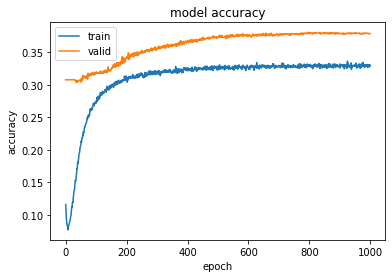

time: 324 ms (started: 2022-11-20 20:35:55 +00:00)


In [17]:
# Summarize history for accuracy.

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

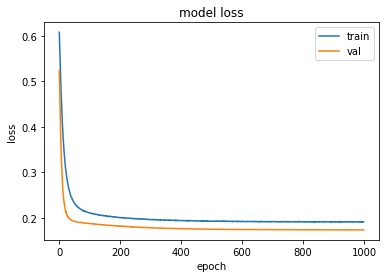

time: 160 ms (started: 2022-11-20 20:35:55 +00:00)


In [18]:
# Summarize history for loss.

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### Define test pipeline.

In [19]:
class TFRecordPipelineTest(Pipeline):
    def __init__(self, batch_size, num_threads,
                 device = 'cpu', device_id = 0):
        super(TFRecordPipelineTest, self).__init__(batch_size,
                                         num_threads,
                                         device_id)
        self.input = fn.readers.tfrecord(        
             features = {"image_raw": tfrec.FixedLenFeature((), tfrec.string, ""),
                         "label": tfrec.FixedLenFeature([24], tfrec.int64,  24)},
             path = ['/content/drive/MyDrive/facial_emotion_recognition_using_K-drama_dataset-main/tfrecords/multi-label_test.tfrecords'],
             index_path = ['/content/drive/MyDrive/facial_emotion_recognition_using_K-drama_dataset-main/tfrecords/multi-label_test.idx'],
             random_shuffle=False,
             seed = set_seed)
        self.iter = 0
    def define_graph(self):
        inputs = self.input
        images = fn.decoders.image(inputs["image_raw"], device = "mixed", output_type = types.RGB) / 255.
        labels = inputs["label"].gpu()
        return (images, labels)
    def iter_setup(self):
        pass

time: 5.69 ms (started: 2022-11-20 20:35:55 +00:00)


### Check test data accuracy.

In [20]:
# https://docs.nvidia.com/deeplearning/dali/user-guide/docs/plugins/tensorflow_plugin_api.html

if __name__ == "__main__":
    batch_size = 1
    shapes = ((batch_size, 64, 64, 3),
              (batch_size, 24))
    pipe_test = TFRecordPipelineTest(batch_size=batch_size, 
                            num_threads=4, 
                            device='gpu', 
                            device_id=0)

    with tf.device('/gpu:0'):
        ds_test = dali_tf.DALIDataset(
            pipeline=pipe_test,
            batch_size=batch_size,
            output_shapes=shapes,
            output_dtypes=(tf.float32, tf.int64),
            device_id=0)
        print(ds_test)
        loss, acc = clf.evaluate(ds_test, steps=TEST_DATA_SIZE)
        print("Test accuracy:", acc)
        predictions = clf.predict(ds_test.take(5))
        print("A test output from the last layer:", predictions[0])
        print("Index of the maximum value:", np.argmax(predictions[0]))
        print("Label:", LABELS[np.argmax(predictions[0])])

<DALIDataset element_spec=(TensorSpec(shape=(1, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1, 24), dtype=tf.int64, name=None))>
3882/3882 [==============================] - 22s 6ms/step - loss: 0.1708 - accuracy: 0.3931
Test accuracy: 0.39309632778167725
5/5 [==============================] - 1s 7ms/step
A test output from the last layer: [1.3301020e-02 2.2660965e-02 7.3465344e-05 1.1733641e-01 2.6089981e-01
 4.5233462e-02 9.1127172e-02 2.7678655e-02 7.4128643e-02 2.7176617e-03
 9.0985307e-03 2.6436317e-01 2.3171414e-01 1.0278863e-01 1.7719386e-03
 4.0709596e-02 3.3325456e-02 3.5682958e-02 8.0687031e-02 1.2107385e-05
 2.2135474e-02 9.7011989e-03 6.6611424e-02 2.4943767e-02]
Index of the maximum value: 11
Label: sad
time: 23.1 s (started: 2022-11-20 20:35:55 +00:00)


In [21]:
predictions

array([[1.3301020e-02, 2.2660965e-02, 7.3465344e-05, 1.1733641e-01,
        2.6089981e-01, 4.5233462e-02, 9.1127172e-02, 2.7678655e-02,
        7.4128643e-02, 2.7176617e-03, 9.0985307e-03, 2.6436317e-01,
        2.3171414e-01, 1.0278863e-01, 1.7719386e-03, 4.0709596e-02,
        3.3325456e-02, 3.5682958e-02, 8.0687031e-02, 1.2107385e-05,
        2.2135474e-02, 9.7011989e-03, 6.6611424e-02, 2.4943767e-02],
       [1.6944531e-02, 2.1339765e-02, 6.6850072e-05, 1.2019212e-01,
        3.0877843e-01, 5.3260040e-02, 4.2782448e-02, 2.7304836e-02,
        1.0252527e-01, 2.4792759e-03, 9.6309045e-03, 2.4943349e-01,
        1.9614308e-01, 4.1343443e-02, 1.9285860e-03, 3.8453195e-02,
        1.4139952e-02, 2.6099879e-02, 3.3306275e-02, 3.9612432e-06,
        2.3358280e-02, 4.9367533e-03, 1.6831661e-02, 2.0081479e-02],
       [5.2115950e-03, 4.7792867e-03, 2.5367567e-06, 5.4377664e-02,
        3.9645833e-01, 2.2591064e-02, 3.0479964e-02, 9.9191898e-03,
        5.8791716e-02, 1.3468701e-03, 1.916057

time: 5.44 ms (started: 2022-11-20 20:36:18 +00:00)


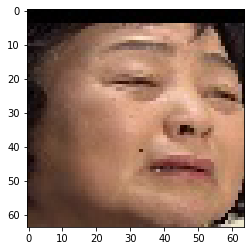

time: 386 ms (started: 2022-11-20 20:36:18 +00:00)


In [22]:
# Display the tested image.

import matplotlib.pyplot as plt

data, = ds_test.take(1)
plt.imshow(data[0][0])

In [23]:
# Check the test data's true label.
data[1]

<tf.Tensor: shape=(1, 24), dtype=int64, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]])>

time: 8.44 ms (started: 2022-11-20 20:36:19 +00:00)


### Result: Argmax Accuracy & Micro F1-score

In [24]:
pred_test = clf.predict(ds_test.take(TEST_DATA_SIZE))

3882/3882 [==============================] - 10s 3ms/step
time: 10.9 s (started: 2022-11-20 20:36:19 +00:00)


In [25]:
true_test = np.concatenate([y for x, y in ds_test.take(TEST_DATA_SIZE)], axis=0)

time: 2.1 s (started: 2022-11-20 20:36:30 +00:00)


In [26]:
true_test.shape

(3882, 24)

time: 6.89 ms (started: 2022-11-20 20:36:32 +00:00)


In [27]:
from sklearn.metrics import accuracy_score, f1_score

true_test_ls = []
pred_test_ls = []

for (true, pred) in zip(true_test, pred_test):
    true_test_ls.append(np.argmax(true))
    pred_test_ls.append(np.argmax(pred))

argmax_acc = accuracy_score(true_test_ls, pred_test_ls)
f1_micro = f1_score(true_test_ls, pred_test_ls, average='micro')

print("argmax accuracy:", argmax_acc)
print("f1_micro:", f1_micro)

argmax accuracy: 0.3930963420917053
f1_micro: 0.3930963420917053
time: 172 ms (started: 2022-11-20 20:36:32 +00:00)


### Result: Threshold=0.5 Accuracy & Micro F1-score

In [28]:
pred_05 = pred_test.copy()
pred_05

array([[1.3301020e-02, 2.2660971e-02, 7.3465410e-05, ..., 9.7012045e-03,
        6.6611432e-02, 2.4943775e-02],
       [1.6944515e-02, 2.1339748e-02, 6.6849942e-05, ..., 4.9367482e-03,
        1.6831653e-02, 2.0081466e-02],
       [5.2115922e-03, 4.7792848e-03, 2.5367567e-06, ..., 2.7927908e-03,
        2.4331305e-02, 1.4724691e-02],
       ...,
       [2.9144275e-03, 1.9748106e-03, 5.1130866e-07, ..., 2.5411980e-04,
        2.5136760e-02, 1.8783853e-03],
       [2.4907911e-02, 7.0090592e-02, 2.3185238e-04, ..., 1.9718267e-02,
        4.0410709e-02, 3.8065575e-02],
       [9.9567510e-03, 9.6702166e-03, 2.6380072e-05, ..., 4.9229562e-03,
        8.4688634e-02, 1.7638374e-02]], dtype=float32)

time: 7.9 ms (started: 2022-11-20 20:36:32 +00:00)


In [29]:
for ls in pred_05:
    thres = 0.5
    pred_05[pred_05 >= thres] = 1
    pred_05[pred_05 < thres] = 0
pred_05[0] 

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

time: 523 ms (started: 2022-11-20 20:36:32 +00:00)


In [30]:
accuracy_score(true_test, pred_05)

0.027820710973724884

time: 16.7 ms (started: 2022-11-20 20:36:33 +00:00)


In [31]:
f1_score(true_test, pred_05, average='micro')

0.08739278200356043

time: 16.7 ms (started: 2022-11-20 20:36:33 +00:00)


### Result: Threshold=0.4 Accuracy & Micro F1-score

In [32]:
pred_04 = pred_test.copy()
for ls in pred_04:
    thres = 0.4
    pred_04[pred_04 >= thres] = 1
    pred_04[pred_04 < thres] = 0
pred_04[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

time: 633 ms (started: 2022-11-20 20:36:33 +00:00)


In [33]:
accuracy_score(true_test, pred_04)

0.11823802163833076

time: 10.6 ms (started: 2022-11-20 20:36:33 +00:00)


In [34]:
f1_score(true_test, pred_04, average='micro')

0.22937740418863087

time: 17.8 ms (started: 2022-11-20 20:36:33 +00:00)


### Result: Threshold=0.3 Accuracy & Micro F1-score

In [35]:
pred_03 = pred_test.copy()
for ls in pred_03:
    thres = 0.3
    pred_03[pred_03 >= thres] = 1
    pred_03[pred_03 < thres] = 0
pred_03[0] 

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

time: 836 ms (started: 2022-11-20 20:36:33 +00:00)


In [36]:
accuracy_score(true_test, pred_03)

0.1955177743431221

time: 11 ms (started: 2022-11-20 20:36:34 +00:00)


In [37]:
f1_score(true_test, pred_03, average='micro')

0.34919249236141425

time: 17.2 ms (started: 2022-11-20 20:36:34 +00:00)


### Result: Threshold=0.2 Accuracy & Micro F1-score

In [38]:
pred_02 = pred_test.copy()
for ls in pred_02:
    thres = 0.2
    pred_02[pred_02 >= thres] = 1
    pred_02[pred_02 < thres] = 0
pred_02[0] 

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

time: 1.09 s (started: 2022-11-20 20:36:34 +00:00)


In [39]:
accuracy_score(true_test, pred_02)

0.1151468315301391

time: 11.4 ms (started: 2022-11-20 20:36:35 +00:00)


In [40]:
f1_score(true_test, pred_02, average='micro')

0.413759419480882

time: 17.8 ms (started: 2022-11-20 20:36:35 +00:00)


### Result: Threshold=0.1 Accuracy & Micro F1-score

In [41]:
pred_01 = pred_test.copy()
for ls in pred_01:
    thres = 0.1
    pred_01[pred_01 >= thres] = 1
    pred_01[pred_01 < thres] = 0
pred_01[0] 

array([0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

time: 1.51 s (started: 2022-11-20 20:36:35 +00:00)


In [42]:
accuracy_score(true_test, pred_01)

0.0077279752704791345

time: 11.4 ms (started: 2022-11-20 20:36:37 +00:00)


In [43]:
f1_score(true_test, pred_01, average='micro')

0.36884735202492214

time: 17 ms (started: 2022-11-20 20:36:37 +00:00)


time: 27.1 ms (started: 2022-11-20 20:36:37 +00:00)
